# Method 5 - Best Ideas

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data.groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

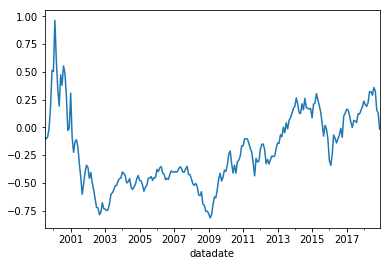

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.512625
2000-12-31   -0.343190
2001-12-31   -0.337445
2002-12-31   -0.593746
2003-12-31    1.034104
2004-12-31    0.039706
2005-12-31   -0.035902
2006-12-31    0.096238
2007-12-31   -0.040151
2008-12-31   -0.574488
2009-12-31    1.516882
2010-12-31    0.355886
2011-12-31   -0.166581
2012-12-31    0.166675
2013-12-31    0.446214
2014-12-31   -0.001435
2015-12-31   -0.234509
2016-12-31    0.259009
2017-12-31    0.051305
2018-12-31   -0.170808
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     281.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.64e-87
Time:                        05:38:44   Log-Likelihood:                 384.19
No. Observations:                 234   AIC:                            -758.4
Df Residuals:                     229   BIC:                            -741.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.003      1.232      0.219      -0.002       0.010
mktrf          1.3585      0.088     15.379      0.000       1.184       1.533
me             0.6773      0.103      6.592      0.000       0.475       0.880
ia            -0.2028      0.156     -1.298      0.195      -0.510       0.105
roe           -1.4647      0.134    -10.957      0.000      -1.728      -1.201
==============================================================================
Omnibus:                      145.759   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2120.177
Skew:                           2.130   Prob(JB):                         0.00
Kurtosis:                      17.118   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     180.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.32e-69
Time:                        05:38:45   Log-Likelihood:                 384.19
No. Observations:                 234   AIC:                            -758.4
Df Residuals:                     229   BIC:                            -741.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.003      1.210      0.226      -0.002       0.010
mktrf          1.3585      0.169      8.035      0.000       1.027       1.690
me             0.6773      0.126      5.396      0.000       0.431       0.923
ia            -0.2028      0.212     -0.957      0.338      -0.618       0.212
roe           -1.4647      0.202     -7.252      0.000      -1.861      -1.069
==============================================================================
Omnibus:                      145.759   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2120.177
Skew:                           2.130   Prob(JB):                         0.00
Kurtosis:                      17.118   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     218.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.97e-77
Time:                        05:38:45   Log-Likelihood:                 384.19
No. Observations:                 234   AIC:                            -758.4
Df Residuals:                     229   BIC:                            -741.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.004      1.126      0.260      -0.003       0.011
mktrf          1.3585      0.170      7.985      0.000       1.025       1.692
me             0.6773      0.139      4.862      0.000       0.404       0.950
ia            -0.2028      0.207     -0.981      0.326      -0.608       0.202
roe           -1.4647      0.218     -6.727      0.000      -1.891      -1.038
==============================================================================
Omnibus:                      145.759   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2120.177
Skew:                           2.130   Prob(JB):                         0.00
Kurtosis:                      17.118   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     198.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.63e-81
Time:                        05:38:45   Log-Likelihood:                 372.17
No. Observations:                 234   AIC:                            -732.3
Df Residuals:                     228   BIC:                            -711.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.003      0.855      0.393      -0.004       0.010
mktrf          1.5061      0.093     16.130      0.000       1.322       1.690
smb            0.7000      0.123      5.681      0.000       0.457       0.943
hml            0.1541      0.145      1.061      0.290      -0.132       0.440
rmw           -1.3604      0.164     -8.283      0.000      -1.684      -1.037
cma           -0.0403      0.209     -0.193      0.847      -0.452       0.371
==============================================================================
Omnibus:                      137.178   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1108.921
Skew:                           2.199   Prob(JB):                    1.59e-241
Kurtosis:                      12.716   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     128.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.51e-64
Time:                        05:38:45   Log-Likelihood:                 372.17
No. Observations:                 234   AIC:                            -732.3
Df Residuals:                     228   BIC:                            -711.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.004      0.830      0.407      -0.004       0.010
mktrf          1.5061      0.110     13.700      0.000       1.291       1.722
smb            0.7000      0.116      6.041      0.000       0.473       0.927
hml            0.1541      0.246      0.627      0.531      -0.328       0.636
rmw           -1.3604      0.204     -6.660      0.000      -1.761      -0.960
cma           -0.0403      0.308     -0.131      0.896      -0.643       0.563
==============================================================================
Omnibus:                      137.178   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1108.921
Skew:                           2.199   Prob(JB):                    1.59e-241
Kurtosis:                      12.716   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     141.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.15e-68
Time:                        05:38:45   Log-Likelihood:                 372.17
No. Observations:                 234   AIC:                            -732.3
Df Residuals:                     228   BIC:                            -711.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.004      0.755      0.451      -0.005       0.011
mktrf          1.5061      0.098     15.371      0.000       1.314       1.698
smb            0.7000      0.118      5.947      0.000       0.469       0.931
hml            0.1541      0.202      0.763      0.445      -0.242       0.550
rmw           -1.3604      0.213     -6.397      0.000      -1.777      -0.944
cma           -0.0403      0.284     -0.142      0.887      -0.596       0.516
==============================================================================
Omnibus:                      137.178   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1108.921
Skew:                           2.199   Prob(JB):                    1.59e-241
Kurtosis:                      12.716   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     241.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.23e-81
Time:                        05:38:45   Log-Likelihood:                 369.34
No. Observations:                 234   AIC:                            -728.7
Df Residuals:                     229   BIC:                            -711.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.003     -0.347      0.729      -0.008       0.005
mktrf          1.6027      0.087     18.495      0.000       1.432       1.773
smb            1.3380      0.108     12.369      0.000       1.125       1.551
hml           -0.2174      0.107     -2.023      0.044      -0.429      -0.006
umd           -0.5258      0.071     -7.458      0.000      -0.665      -0.387
==============================================================================
Omnibus:                      113.421   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              959.739
Skew:                           1.692   Prob(JB):                    3.94e-209
Kurtosis:                      12.327   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     98.81
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.00e-48
Time:                        05:38:45   Log-Likelihood:                 369.34
No. Observations:                 234   AIC:                            -728.7
Df Residuals:                     229   BIC:                            -711.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.003     -0.377      0.706      -0.007       0.005
mktrf          1.6027      0.138     11.604      0.000       1.332       1.873
smb            1.3380      0.125     10.721      0.000       1.093       1.583
hml           -0.2174      0.169     -1.287      0.198      -0.549       0.114
umd           -0.5258      0.111     -4.750      0.000      -0.743      -0.309
==============================================================================
Omnibus:                      113.421   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              959.739
Skew:                           1.692   Prob(JB):                    3.94e-209
Kurtosis:                      12.327   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     93.57
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.87e-47
Time:                        05:38:45   Log-Likelihood:                 369.34
No. Observations:                 234   AIC:                            -728.7
Df Residuals:                     229   BIC:                            -711.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.003     -0.370      0.711      -0.007       0.005
mktrf          1.6027      0.133     12.071      0.000       1.342       1.863
smb            1.3380      0.121     11.090      0.000       1.102       1.574
hml           -0.2174      0.160     -1.357      0.175      -0.532       0.097
umd           -0.5258      0.112     -4.691      0.000      -0.745      -0.306
==============================================================================
Omnibus:                      113.421   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              959.739
Skew:                           1.692   Prob(JB):                    3.94e-209
Kurtosis:                      12.327   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     138.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.28e-43
Time:                        05:38:45   Log-Likelihood:                 176.64
No. Observations:                 120   AIC:                            -343.3
Df Residuals:                     115   BIC:                            -329.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0079      0.005      1.452      0.149      -0.003       0.019
mktrf          1.2261      0.146      8.387      0.000       0.937       1.516
me             0.5992      0.144      4.150      0.000       0.313       0.885
ia            -0.4576      0.226     -2.024      0.045      -0.905      -0.010
roe           -1.5020      0.200     -7.506      0.000      -1.898      -1.106
==============================================================================
Omnibus:                       68.084   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              490.783
Skew:                           1.751   Prob(JB):                    2.68e-107
Kurtosis:                      12.268   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     171.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.73e-47
Time:                        05:38:45   Log-Likelihood:                 176.64
No. Observations:                 120   AIC:                            -343.3
Df Residuals:                     115   BIC:                            -329.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0079      0.005      1.606      0.108      -0.002       0.017
mktrf          1.2261      0.256      4.798      0.000       0.725       1.727
me             0.5992      0.168      3.564      0.000       0.270       0.929
ia            -0.4576      0.293     -1.564      0.118      -1.031       0.116
roe           -1.5020      0.282     -5.333      0.000      -2.054      -0.950
==============================================================================
Omnibus:                       68.084   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              490.783
Skew:                           1.751   Prob(JB):                    2.68e-107
Kurtosis:                      12.268   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     257.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.34e-56
Time:                        05:38:45   Log-Likelihood:                 176.64
No. Observations:                 120   AIC:                            -343.3
Df Residuals:                     115   BIC:                            -329.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0079      0.005      1.602      0.109      -0.002       0.018
mktrf          1.2261      0.259      4.735      0.000       0.719       1.734
me             0.5992      0.185      3.236      0.001       0.236       0.962
ia            -0.4576      0.270     -1.694      0.090      -0.987       0.072
roe           -1.5020      0.316     -4.746      0.000      -2.122      -0.882
==============================================================================
Omnibus:                       68.084   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              490.783
Skew:                           1.751   Prob(JB):                    2.68e-107
Kurtosis:                      12.268   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     99.71
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.87e-40
Time:                        05:38:45   Log-Likelihood:                 171.90
No. Observations:                 120   AIC:                            -331.8
Df Residuals:                     114   BIC:                            -315.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0084      0.006      1.437      0.153      -0.003       0.020
mktrf          1.5551      0.161      9.655      0.000       1.236       1.874
smb            0.6775      0.182      3.714      0.000       0.316       1.039
hml           -0.1648      0.224     -0.737      0.462      -0.608       0.278
rmw           -1.1414      0.264     -4.330      0.000      -1.664      -0.619
cma           -0.0189      0.289     -0.066      0.948      -0.591       0.553
==============================================================================
Omnibus:                       76.625   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              390.567
Skew:                           2.240   Prob(JB):                     1.55e-85
Kurtosis:                      10.618   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     66.26
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.04e-32
Time:                        05:38:45   Log-Likelihood:                 171.90
No. Observations:                 120   AIC:                            -331.8
Df Residuals:                     114   BIC:                            -315.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0084      0.005      1.759      0.079      -0.001       0.018
mktrf          1.5551      0.196      7.947      0.000       1.172       1.939
smb            0.6775      0.174      3.904      0.000       0.337       1.018
hml           -0.1648      0.212     -0.776      0.438      -0.581       0.251
rmw           -1.1414      0.275     -4.144      0.000      -1.681      -0.602
cma           -0.0189      0.343     -0.055      0.956      -0.691       0.653
==============================================================================
Omnibus:                       76.625   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              390.567
Skew:                           2.240   Prob(JB):                     1.55e-85
Kurtosis:                      10.618   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     79.62
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.50e-35
Time:                        05:38:45   Log-Likelihood:                 171.90
No. Observations:                 120   AIC:                            -331.8
Df Residuals:                     114   BIC:                            -315.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0084      0.005      1.674      0.094      -0.001       0.018
mktrf          1.5551      0.162      9.619      0.000       1.238       1.872
smb            0.6775      0.167      4.053      0.000       0.350       1.005
hml           -0.1648      0.173     -0.951      0.342      -0.505       0.175
rmw           -1.1414      0.296     -3.857      0.000      -1.721      -0.561
cma           -0.0189      0.302     -0.063      0.950      -0.610       0.572
==============================================================================
Omnibus:                       76.625   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              390.567
Skew:                           2.240   Prob(JB):                     1.55e-85
Kurtosis:                      10.618   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     139.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.14e-43
Time:                        05:38:45   Log-Likelihood:                 176.90
No. Observations:                 120   AIC:                            -343.8
Df Residuals:                     115   BIC:                            -329.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.005      0.618      0.538      -0.007       0.014
mktrf          1.6126      0.129     12.548      0.000       1.358       1.867
smb            1.2878      0.146      8.801      0.000       0.998       1.578
hml           -0.5020      0.147     -3.425      0.001      -0.792      -0.212
umd           -0.5012      0.090     -5.547      0.000      -0.680      -0.322
==============================================================================
Omnibus:                       65.036   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              418.724
Skew:                           1.697   Prob(JB):                     1.19e-91
Kurtosis:                      11.498   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     103.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.48e-37
Time:                        05:38:45   Log-Likelihood:                 176.90
No. Observations:                 120   AIC:                            -343.8
Df Residuals:                     115   BIC:                            -329.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.004      0.762      0.446      -0.005       0.012
mktrf          1.6126      0.202      7.987      0.000       1.217       2.008
smb            1.2878      0.134      9.584      0.000       1.024       1.551
hml           -0.5020      0.198     -2.530      0.011      -0.891      -0.113
umd           -0.5012      0.114     -4.413      0.000      -0.724      -0.279
==============================================================================
Omnibus:                       65.036   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              418.724
Skew:                           1.697   Prob(JB):                     1.19e-91
Kurtosis:                      11.498   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     136.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.19e-42
Time:                        05:38:45   Log-Likelihood:                 176.90
No. Observations:                 120   AIC:                            -343.8
Df Residuals:                     115   BIC:                            -329.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.004      0.786      0.432      -0.005       0.011
mktrf          1.6126      0.198      8.137      0.000       1.224       2.001
smb            1.2878      0.125     10.303      0.000       1.043       1.533
hml           -0.5020      0.177     -2.829      0.005      -0.850      -0.154
umd           -0.5012      0.119     -4.220      0.000      -0.734      -0.268
==============================================================================
Omnibus:                       65.036   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              418.724
Skew:                           1.697   Prob(JB):                     1.19e-91
Kurtosis:                      11.498   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     165.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.63e-45
Time:                        05:38:45   Log-Likelihood:                 226.87
No. Observations:                 114   AIC:                            -443.7
Df Residuals:                     109   BIC:                            -430.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.003     -0.078      0.938      -0.007       0.006
mktrf          1.4932      0.099     15.017      0.000       1.296       1.690
me             0.7525      0.154      4.901      0.000       0.448       1.057
ia             0.2547      0.213      1.196      0.234      -0.167       0.677
roe           -1.4984      0.187     -8.008      0.000      -1.869      -1.128
==============================================================================
Omnibus:                       22.663   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.035
Skew:                           0.848   Prob(JB):                     1.23e-09
Kurtosis:                       5.401   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     123.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.75e-39
Time:                        05:38:45   Log-Likelihood:                 226.87
No. Observations:                 114   AIC:                            -443.7
Df Residuals:                     109   BIC:                            -430.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.003     -0.099      0.921      -0.005       0.005
mktrf          1.4932      0.120     12.428      0.000       1.258       1.729
me             0.7525      0.204      3.681      0.000       0.352       1.153
ia             0.2547      0.239      1.066      0.286      -0.213       0.723
roe           -1.4984      0.303     -4.948      0.000      -2.092      -0.905
==============================================================================
Omnibus:                       22.663   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.035
Skew:                           0.848   Prob(JB):                     1.23e-09
Kurtosis:                       5.401   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     133.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.65e-41
Time:                        05:38:45   Log-Likelihood:                 226.87
No. Observations:                 114   AIC:                            -443.7
Df Residuals:                     109   BIC:                            -430.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.002     -0.107      0.915      -0.005       0.005
mktrf          1.4932      0.115     13.035      0.000       1.269       1.718
me             0.7525      0.237      3.177      0.001       0.288       1.217
ia             0.2547      0.263      0.968      0.333      -0.261       0.770
roe           -1.4984      0.311     -4.818      0.000      -2.108      -0.889
==============================================================================
Omnibus:                       22.663   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.035
Skew:                           0.848   Prob(JB):                     1.23e-09
Kurtosis:                       5.401   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     119.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.23e-42
Time:                        05:38:45   Log-Likelihood:                 222.50
No. Observations:                 114   AIC:                            -433.0
Df Residuals:                     108   BIC:                            -416.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.004     -0.724      0.471      -0.010       0.004
mktrf          1.5340      0.099     15.495      0.000       1.338       1.730
smb            0.6934      0.161      4.314      0.000       0.375       1.012
hml            0.7112      0.205      3.470      0.001       0.305       1.118
rmw           -1.3360      0.251     -5.323      0.000      -1.834      -0.839
cma           -0.1526      0.319     -0.479      0.633      -0.784       0.479
==============================================================================
Omnibus:                       20.835   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.441
Skew:                           0.636   Prob(JB):                     4.10e-12
Kurtosis:                       6.070   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     108.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.08e-40
Time:                        05:38:45   Log-Likelihood:                 222.50
No. Observations:                 114   AIC:                            -433.0
Df Residuals:                     108   BIC:                            -416.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.004     -0.674      0.500      -0.010       0.005
mktrf          1.5340      0.092     16.666      0.000       1.354       1.714
smb            0.6934      0.160      4.320      0.000       0.379       1.008
hml            0.7112      0.188      3.785      0.000       0.343       1.080
rmw           -1.3360      0.299     -4.469      0.000      -1.922      -0.750
cma           -0.1526      0.284     -0.538      0.590      -0.708       0.403
==============================================================================
Omnibus:                       20.835   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.441
Skew:                           0.636   Prob(JB):                     4.10e-12
Kurtosis:                       6.070   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     116.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.90e-42
Time:                        05:38:45   Log-Likelihood:                 222.50
No. Observations:                 114   AIC:                            -433.0
Df Residuals:                     108   BIC:                            -416.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.004     -0.689      0.491      -0.010       0.005
mktrf          1.5340      0.095     16.219      0.000       1.349       1.719
smb            0.6934      0.178      3.904      0.000       0.345       1.041
hml            0.7112      0.161      4.412      0.000       0.395       1.027
rmw           -1.3360      0.272     -4.908      0.000      -1.870      -0.803
cma           -0.1526      0.303     -0.503      0.615      -0.747       0.442
==============================================================================
Omnibus:                       20.835   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.441
Skew:                           0.636   Prob(JB):                     4.10e-12
Kurtosis:                       6.070   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     127.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.24e-40
Time:                        05:38:45   Log-Likelihood:                 214.57
No. Observations:                 114   AIC:                            -419.1
Df Residuals:                     109   BIC:                            -405.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0037      0.004     -0.993      0.323      -0.011       0.004
mktrf          1.5779      0.105     15.032      0.000       1.370       1.786
smb            1.0084      0.164      6.161      0.000       0.684       1.333
hml            0.6377      0.169      3.783      0.000       0.304       0.972
umd           -0.4597      0.127     -3.615      0.000      -0.712      -0.208
==============================================================================
Omnibus:                       25.748   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.677
Skew:                           0.751   Prob(JB):                     3.69e-17
Kurtosis:                       6.698   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     149.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.89e-43
Time:                        05:38:45   Log-Likelihood:                 214.57
No. Observations:                 114   AIC:                            -419.1
Df Residuals:                     109   BIC:                            -405.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0037      0.003     -1.133      0.257      -0.010       0.003
mktrf          1.5779      0.103     15.354      0.000       1.377       1.779
smb            1.0084      0.165      6.120      0.000       0.685       1.331
hml            0.6377      0.191      3.337      0.001       0.263       1.012
umd           -0.4597      0.122     -3.765      0.000      -0.699      -0.220
==============================================================================
Omnibus:                       25.748   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.677
Skew:                           0.751   Prob(JB):                     3.69e-17
Kurtosis:                       6.698   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     193.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.61e-48
Time:                        05:38:45   Log-Likelihood:                 214.57
No. Observations:                 114   AIC:                            -419.1
Df Residuals:                     109   BIC:                            -405.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0037      0.003     -1.179      0.238      -0.010       0.002
mktrf          1.5779      0.100     15.715      0.000       1.381       1.775
smb            1.0084      0.152      6.618      0.000       0.710       1.307
hml            0.6377      0.191      3.344      0.001       0.264       1.011
umd           -0.4597      0.119     -3.860      0.000      -0.693      -0.226
==============================================================================
Omnibus:                       25.748   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.677
Skew:                           0.751   Prob(JB):                     3.69e-17
Kurtosis:                       6.698   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""